# Наивный Байес и спам
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW10] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
import string
from nltk.stem.snowball import SnowballStemmer
from typing import NoReturn

In [2]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [3]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [4]:
X, y = read_dataset("spam")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [6]:
class NaiveBayes:
    def __init__(self, alpha: float):
        """
        Parameters
        ----------
        alpha : float
            Параметр аддитивной регуляризации.
        """
        self.alpha = alpha
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Оценивает параметры распределения p(x|y) для каждого y.
        """
        
        n, voc_size = X.shape
        labels = np.unique(y)
        self.classes = labels
        self.thetas = np.zeros((len(labels), voc_size))
        self.y_prob = np.array([])
        
        for i, label in enumerate(labels):
            data = X[y == label]
            self.y_prob = np.append(self.y_prob, data.shape[0]  / n )
            
            total = data.sum()
            cnt_words = data.sum(axis=0)
            theta = (cnt_words + self.alpha) / (total + self.alpha * voc_size)
            
            self.thetas[i] = theta
        
        
    def predict(self, X: np.ndarray) -> list:
        """
        Return
        ------
        list
            Предсказанный класс для каждого элемента из набора X.
        """
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Return
        ------
        np.ndarray
            Для каждого элемента набора X - логарифм вероятности отнести его к каждому классу. 
            Матрица размера (X.shape[0], n_classes)
        """
        thetas = np.log(self.thetas)
        y_prob = np.log(self.y_prob)
        log_probs = np.zeros((X.shape[0], thetas.shape[0]))
        
        for j, theta_j in enumerate(thetas):
            log_probs[:, j] = y_prob[j] + X @ theta_j
        
        return log_probs

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [22]:
class BoW:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):
        """
        Составляет словарь, который будет использоваться для векторизации предложений.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            по которому будет составляться словарь.
        voc_limit : int
            Максимальное число слов в словаре.

        """
        words = self._prepare_data(X)
        words, cnt = np.unique(words, return_counts=True)
        top_k = np.argpartition(cnt, -voc_limit)[-voc_limit:]
        
        self.vocabulary = words[top_k]
        self.voc_limit = voc_limit
        
    def _prepare_data(self, X: np.ndarray, is_sentence=False) -> np.ndarray:
        if is_sentence:
            words = X.split()
        else:
            words = []
            for s in X:
                words += s.split()

        for i, w in enumerate(words):
            w = w.translate(str.maketrans('', '', string.punctuation))
            w = w.lower()
            words[i] = w
        
        words = [w for w in words if w != '']
        return words
    
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Векторизует предложения.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            который необходимо векторизовать.
        
        Return
        ------
        np.ndarray
            Матрица векторизованных предложений размерности (n_sentences, vocab_size)
        """
        bow = np.zeros((X.shape[0], self.voc_limit))
        
        for i, x in enumerate(X):
            words = self._prepare_data(x, is_sentence=True)
            bow_x = np.zeros((self.voc_limit,))
            
            for word in words:
                bow_x = bow_x + (self.vocabulary == word)
                
            bow[i] = bow_x
        
        return bow

In [23]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [9]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9739478957915831, 'spam': 0.9152542372881356},
 {'ham': 0.9898167006109979, 'spam': 0.8059701492537313},
 0.967741935483871)

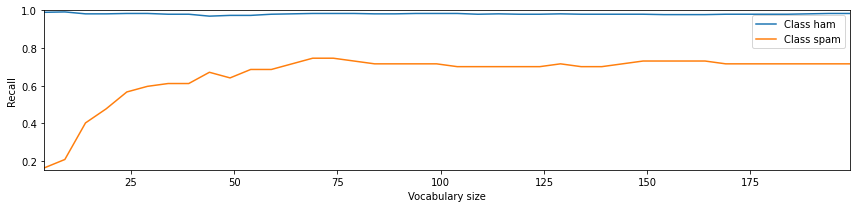

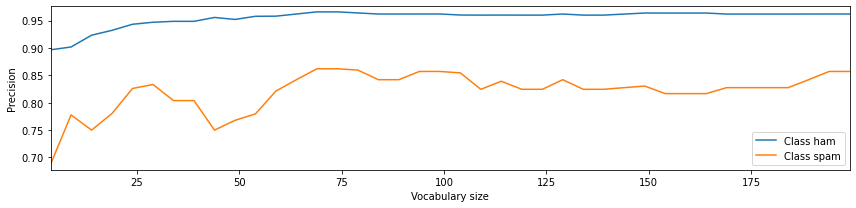

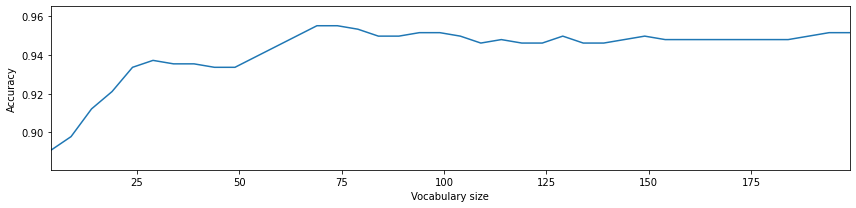

In [10]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [18]:
class BowStem:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):
        """
        Составляет словарь, который будет использоваться для векторизации предложений.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            по которому будет составляться словарь.
        voc_limit : int
            Максимальное число слов в словаре.

        """
        self.stemmer = SnowballStemmer(language='english')
        words = self._prepare_data(X)
        words = [self.stemmer.stem(word) for word in words]
        words, cnt = np.unique(words, return_counts=True)
        top_k = np.argpartition(cnt, -voc_limit)[-voc_limit:]
        
        self.vocabulary = words[top_k]
        self.voc_limit = voc_limit
        
        
    def _prepare_data(self, X: np.ndarray, is_sentence=False) -> np.ndarray:
        if is_sentence:
            words = X.split()
        else:
            words = []
            for s in X:
                words += s.split()

        for i, w in enumerate(words):
            w = w.translate(str.maketrans('', '', string.punctuation))
            w = w.lower()
            words[i] = w
        
        words = [w for w in words if w != '']
        return words
    
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Векторизует предложения.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            который необходимо векторизовать.
        
        Return
        ------
        np.ndarray
            Матрица векторизованных предложений размерности (n_sentences, vocab_size)
        """
        bow = np.zeros((X.shape[0], self.voc_limit))
        
        for i, x in enumerate(X):
            words = self._prepare_data(x, is_sentence=True)
            words = [self.stemmer.stem(word) for word in words]
            bow_x = np.zeros((self.voc_limit,))
            
            for word in words:
                bow_x = bow_x + (self.vocabulary == word)
                
            bow[i] = bow_x
        
        return bow

In [19]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [13]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.971830985915493, 'spam': 0.8688524590163934},
 {'ham': 0.9837067209775967, 'spam': 0.7910447761194029},
 0.9605734767025089)

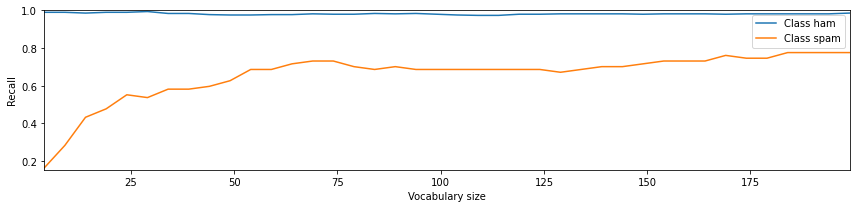

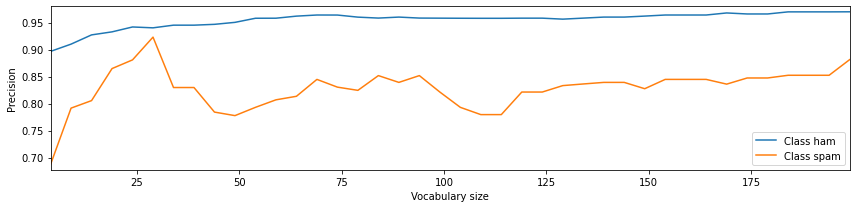

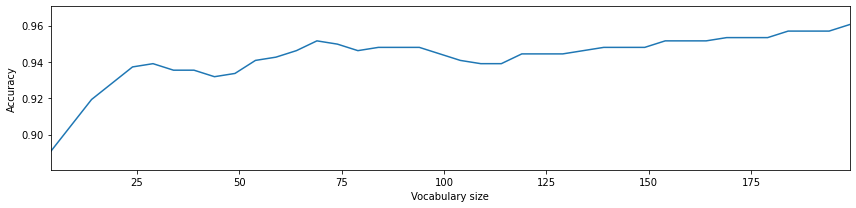

In [14]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)